# Peter ve Kurt: Pekiştirmeli Öğrenme Giriş

Bu eğitimde, bir yol bulma problemine Pekiştirmeli Öğrenme uygulamayı öğreneceğiz. Ayar, Rus besteci [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev) tarafından yazılan [Peter ve Kurt](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) adlı müzikal masaldan esinlenmiştir. Bu, genç öncü Peter'in cesurca evinden çıkıp kurtu kovalamak için orman açıklığına gittiği bir hikayedir. Peter'in çevresini keşfetmesine ve en uygun navigasyon haritasını oluşturmasına yardımcı olacak makine öğrenimi algoritmalarını eğiteceğiz.

Öncelikle, bir dizi kullanışlı kütüphane ithal edelim:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Pekiştirmeli Öğrenmeye Genel Bakış

**Pekiştirmeli Öğrenme** (RL), bir **ajanın** belirli bir **ortamda** birçok deney yaparak en uygun davranışı öğrenmesini sağlayan bir öğrenme tekniğidir. Bu ortamda bir ajanın, bir **ödül fonksiyonu** ile tanımlanan bir **hedefi** olmalıdır.

## Ortam

Basitlik açısından, Peter'ın dünyasını `genişlik` x `yükseklik` boyutlarında bir kare tahta olarak düşünelim. Bu tahtadaki her bir hücre şu şekilde olabilir:
* Peter ve diğer canlıların yürüyebileceği bir **zemin**
* Üzerinde yürüyemeyeceğiniz açık bir şekilde belli olan **su**
* Dinlenebileceğiniz bir yer olan **ağaç** veya **çimen**
* Peter'ın kendini beslemek için bulmaktan memnun olacağı bir **elma**
* Tehlikeli olan ve kaçınılması gereken bir **kurt**

Ortamla çalışmak için `Board` adında bir sınıf tanımlayacağız. Bu defteri çok fazla karmaşıklaştırmamak adına, tahtayla çalışmak için gereken tüm kodu ayrı bir `rlboard` modülüne taşıdık ve şimdi bu modülü içe aktaracağız. Uygulamanın iç detaylarını görmek için bu modülün içine bakabilirsiniz.


In [2]:
from rlboard import *

Şimdi rastgele bir tahta oluşturalım ve nasıl göründüğüne bakalım:


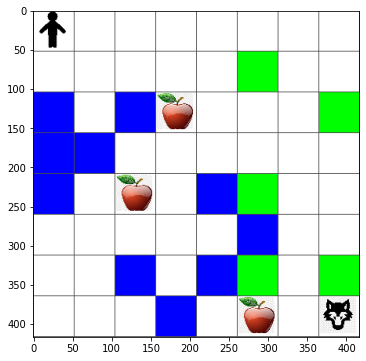

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Eylemler ve Politika

Örneğimizde, Peter'ın amacı bir elma bulmak, aynı zamanda kurttan ve diğer engellerden kaçınmaktır. Bunu yapmak için, elmayı bulana kadar etrafta dolaşabilir. Bu nedenle, herhangi bir konumda yukarı, aşağı, sola ve sağa olmak üzere dört eylemden birini seçebilir. Bu eylemleri bir sözlük olarak tanımlayacağız ve bunları ilgili koordinat değişiklik çiftlerine eşleyeceğiz. Örneğin, sağa hareket etmek (`R`) bir çift `(1,0)` ile eşleşir.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Ajanımızın (Peter) stratejisi, **politika** olarak adlandırılan bir kavramla tanımlanır. En basit politika olan **rastgele yürüyüş**ü ele alalım.

## Rastgele yürüyüş

Öncelikle, rastgele yürüyüş stratejisini uygulayarak problemimizi çözelim.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Rastgele yürüyüş deneyini birkaç kez gerçekleştirelim ve alınan ortalama adım sayısını görelim:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Ödül Fonksiyonu

Politikamızı daha akıllı hale getirmek için, hangi hamlelerin diğerlerinden "daha iyi" olduğunu anlamamız gerekiyor.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Öğrenme

Bir Q-Tablosu veya çok boyutlu bir dizi oluşturun. Tahtamızın boyutları `genişlik` x `yükseklik` olduğundan, Q-Tablosunu `genişlik` x `yükseklik` x `len(actions)` şeklinde bir numpy dizisi ile temsil edebiliriz:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Q-Tablosunu tahtada görselleştirmek için tabloyu plot fonksiyonuna geçirin:


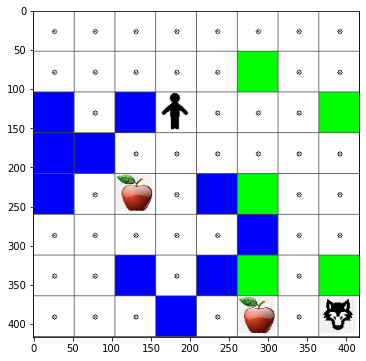

In [9]:
m.plot(Q)

## Q-Öğrenmenin Özeti: Bellman Denklemi ve Öğrenme Algoritması

Öğrenme algoritmamız için bir sözde kod yazın:

* Tüm durumlar ve eylemler için Q-Tablosu Q'yu eşit sayılarla başlatın
* Öğrenme oranını $\alpha\leftarrow 1$ olarak ayarlayın
* Simülasyonu birçok kez tekrarlayın
   1. Rastgele bir pozisyonda başlayın
   1. Tekrarla
        1. Durum $s$'de bir eylem $a$ seçin
        2. Yeni bir duruma $s'$ geçerek eylemi gerçekleştirin
        3. Eğer oyun sonu koşuluyla karşılaşırsak veya toplam ödül çok küçükse - simülasyondan çıkın  
        4. Yeni durumda ödül $r$'yi hesaplayın
        5. Bellman denklemine göre Q-Fonksiyonunu güncelleyin: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Toplam ödülü güncelleyin ve $\alpha$'yı azaltın.

## Keşfet vs. Sömür

En iyi yaklaşım, keşfetme ve sömürme arasında bir denge kurmaktır. Çevremiz hakkında daha fazla bilgi edindikçe, optimal yolu izleme olasılığımız artar, ancak ara sıra keşfedilmemiş bir yolu seçmek faydalı olabilir.

## Python Uygulaması

Artık öğrenme algoritmasını uygulamaya hazırız. Bundan önce, Q-Tablosundaki rastgele sayıları ilgili eylemler için olasılık vektörüne dönüştürecek bir fonksiyona da ihtiyacımız var:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Orijinal vektöre, tüm vektör bileşenlerinin aynı olduğu başlangıç durumunda sıfıra bölünmeyi önlemek için küçük bir miktar `eps` ekliyoruz.

Gerçek öğrenme algoritmasını, **epoklar** olarak da adlandırılan 5000 deney için çalıştıracağız:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Bu algoritmayı çalıştırdıktan sonra, Q-Tablosu her adımda farklı eylemlerin çekiciliğini tanımlayan değerlerle güncellenmelidir. Tabloyu burada görselleştirin:


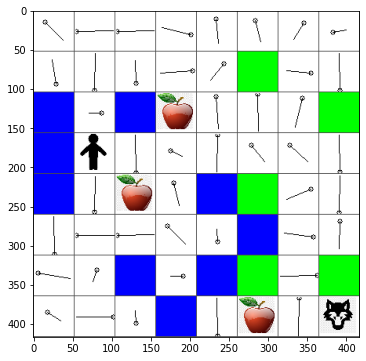

In [12]:
m.plot(Q)

## Politikanın Kontrolü

Q-Tablosu, her durumdaki her bir eylemin "çekiciliğini" listelediği için, dünyamızda verimli bir gezinmeyi tanımlamak için onu kullanmak oldukça kolaydır. En basit durumda, sadece en yüksek Q-Tablosu değerine karşılık gelen eylemi seçebiliriz:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Eğer yukarıdaki kodu birkaç kez denerseniz, bazen sadece "takıldığını" fark edebilirsiniz ve bunu durdurmak için not defterinde DURDUR düğmesine basmanız gerekir.

> **Görev 1:** `walk` fonksiyonunu, yolun maksimum uzunluğunu belirli bir adım sayısıyla (örneğin, 100) sınırlayacak şekilde değiştirin ve yukarıdaki kodun bu değeri zaman zaman döndürdüğünü gözlemleyin.

> **Görev 2:** `walk` fonksiyonunu, daha önce bulunduğu yerlere geri dönmemesini sağlayacak şekilde değiştirin. Bu, `walk` fonksiyonunun döngüye girmesini önleyecektir, ancak ajan yine de kaçamayacağı bir konumda "sıkışabilir".


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


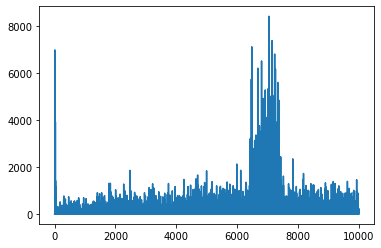

In [15]:
plt.plot(lpath)

Burada gördüğümüz şey, başlangıçta ortalama yol uzunluğunun arttığıdır. Bu muhtemelen çevre hakkında hiçbir şey bilmediğimizde - kötü durumlara, suya veya kurda takılma olasılığımızın yüksek olmasından kaynaklanıyor. Daha fazla bilgi edindikçe ve bu bilgiyi kullanmaya başladıkça, çevreyi daha uzun süre keşfedebiliriz, ancak elmaların nerede olduğunu hâlâ iyi bilmiyoruz.

Yeterince öğrendiğimizde, ajan için hedefe ulaşmak daha kolay hale gelir ve yol uzunluğu azalmaya başlar. Ancak, hâlâ keşfe açık olduğumuz için, genellikle en iyi yoldan sapar ve yeni seçenekleri keşfederiz, bu da yolu optimalden daha uzun hale getirir.

Bu grafikte ayrıca gözlemlediğimiz bir diğer şey, bir noktada uzunluğun aniden arttığıdır. Bu, sürecin stokastik doğasını gösterir ve Q-Tablo katsayılarını yeni değerlerle üzerine yazarak "bozabileceğimiz" anlamına gelir. Bu durum, öğrenme oranını azaltarak (örneğin, eğitimin sonuna doğru Q-Tablo değerlerini yalnızca küçük bir miktarla ayarlayarak) ideal olarak en aza indirgenmelidir.

Genel olarak, öğrenme sürecinin başarısı ve kalitesinin, öğrenme oranı, öğrenme oranı azalması ve indirim faktörü gibi parametrelere önemli ölçüde bağlı olduğunu unutmamak önemlidir. Bunlar genellikle **hiperparametreler** olarak adlandırılır, çünkü eğitim sırasında optimize ettiğimiz **parametrelerden** (örneğin, Q-Tablo katsayıları) ayrılırlar. En iyi hiperparametre değerlerini bulma sürecine **hiperparametre optimizasyonu** denir ve bu ayrı bir konu başlığını hak eder.


## Alıştırma
#### Daha Gerçekçi Bir Peter ve Kurt Dünyası

Bizim senaryomuzda, Peter neredeyse hiç yorulmadan veya acıkmadan etrafta dolaşabiliyordu. Daha gerçekçi bir dünyada, zaman zaman oturup dinlenmesi ve kendini beslemesi gerekiyor. Dünyamızı daha gerçekçi hale getirmek için aşağıdaki kuralları uygulayalım:

1. Bir yerden başka bir yere hareket ettiğinde, Peter **enerji** kaybeder ve biraz **yorgunluk** kazanır.
2. Peter, elma yiyerek daha fazla enerji kazanabilir.
3. Peter, ağacın altında veya çimenlerin üzerinde dinlenerek yorgunluğunu giderebilir (yani, tahtada bir ağaç veya çimen bulunan bir konuma yürümek - yeşil alan).
4. Peter, kurdu bulmalı ve öldürmelidir.
5. Kurdu öldürmek için Peter'ın belirli seviyelerde enerjiye ve yorgunluğa sahip olması gerekir, aksi takdirde savaşı kaybeder.

Yukarıdaki ödül fonksiyonunu oyunun kurallarına göre değiştirin, oyunu kazanmak için en iyi stratejiyi öğrenmek üzere pekiştirmeli öğrenme algoritmasını çalıştırın ve rastgele yürüyüş sonuçlarını algoritmanızla karşılaştırın; kazanılan ve kaybedilen oyun sayısı açısından değerlendirin.

> **Not**: Çalışması için hiperparametreleri ayarlamanız gerekebilir, özellikle epoch sayısını. Çünkü oyunun başarısı (kurdu yenmek) nadir bir olaydır, bu nedenle çok daha uzun bir eğitim süresi bekleyebilirsiniz.



---

**Feragatname**:  
Bu belge, AI çeviri hizmeti [Co-op Translator](https://github.com/Azure/co-op-translator) kullanılarak çevrilmiştir. Doğruluk için çaba göstersek de, otomatik çevirilerin hata veya yanlışlıklar içerebileceğini lütfen unutmayın. Belgenin orijinal dili, yetkili kaynak olarak kabul edilmelidir. Kritik bilgiler için profesyonel insan çevirisi önerilir. Bu çevirinin kullanımından kaynaklanan yanlış anlamalar veya yanlış yorumlamalar için sorumluluk kabul etmiyoruz.
